<center><img src="picture.jpg" width="600" height="500" /></center>

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import concatenate, Input
from tensorflow.keras.models import Model
import tensorflow._api.v2.compat.v1 as tf

tf.disable_v2_behavior()
import tensorflow as tf
from tensorflow.keras import backend as K 

In [14]:
# Define the file paths for input and label data
path_input = 'E:/Deep Course/Weeks/W10/Data/Test(without Uncertainty)/input_file_1.npy'
path_label = 'E:/Deep Course/Weeks/W10/Data/Test(without Uncertainty)/label_file_1.npy'

# Load input data from the specified file path using NumPy
input_data = np.load(path_input)

# Load label data from the specified file path using NumPy
label_data = np.load(path_label)


print(input_data.shape)
print(label_data.shape)

(64, 64, 12)
(64, 64, 1)


In [3]:
# Create an empty NumPy array 'img' with shape (1, 64, 64, 12) and data type 'float32'
img = np.zeros((1, 64, 64, 12), dtype='float32')

# Assign the content of 'input_data' to the first element of 'img' (assuming 'input_data' has compatible dimensions)
img[0] = input_data


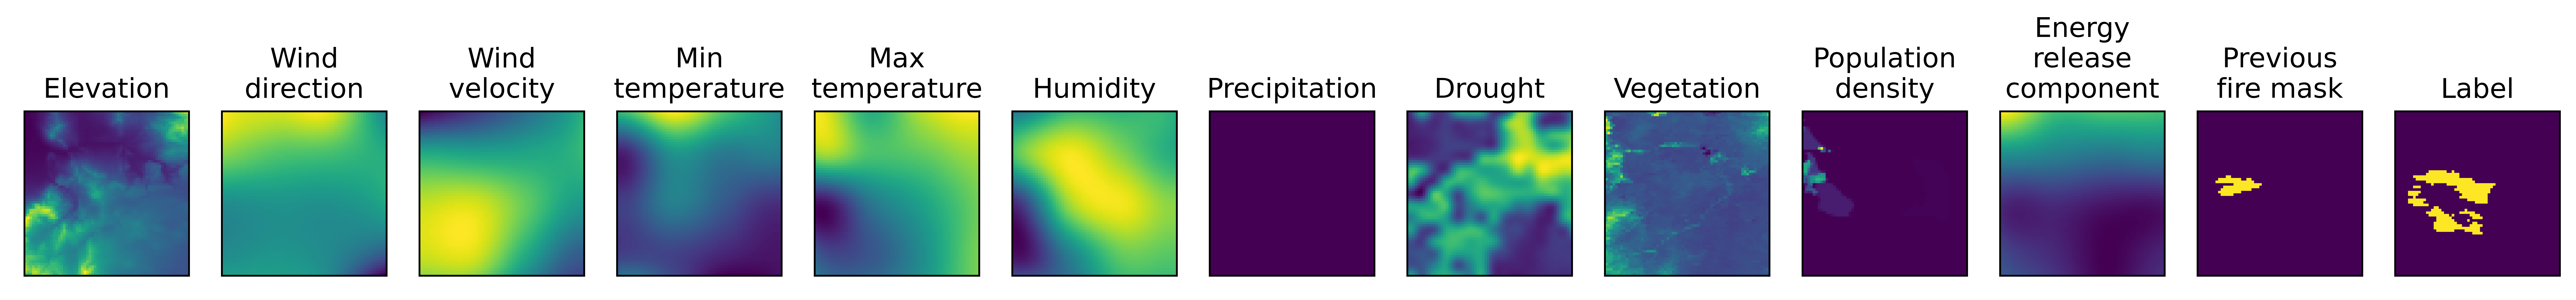

In [4]:
# Define a list of titles for the subplots
TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemperature',
    'Max\ntemperature',
    'Humidity',
    'Precipitation',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire mask',
    'Label',  # Special title for the last subplot
]

# Create a figure with a specified size and DPI
plt.figure(figsize=(20, 10), dpi=1000)

# Iterate through the range of 13 (number of subplots)
for i in range(13):
    if i == 12:
        # For the last subplot, show the label data as an image
        plt.subplot(1, 13, i + 1)
        plt.imshow(label_data[:, :, 0])
        plt.xticks([])
        plt.yticks([])
        plt.title(TITLES[i])  # Set the title for the subplot
    else:
        # For other subplots, show the image data at the i-th channel
        plt.subplot(1, 13, i + 1)
        plt.imshow(img[0, :, :, i])
        plt.xticks([])
        plt.yticks([])
        plt.title(TITLES[i])  # Set the title for the subplot

# Display the entire figure with subplots
plt.show()

In [5]:
model=load_model('E:/Deep Course/Weeks/W10/Models/model-200MC.h5',compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.layers

In [15]:
# Initialize an empty list to store the names of convolutional layers
layers_name = []

# Iterate through the layers of the model
for i in range(len(model.layers)):
    # Get the current layer in the loop
    layer = model.layers[i]
    
    # Check if the layer name contains 'conv' (indicating it's a convolutional layer)
    if 'conv' not in layer.name:
        continue  # Skip non-convolutional layers
    
    # Print the index, name, and output shape of the convolutional layer
    print(i, layer.name, layer.output.shape)
    
    # Append the name of the convolutional layer to the list
    layers_name.append(layer.name)


1 conv2d_187 (?, 64, 64, 64)
2 conv2d_188 (?, 64, 64, 128)
3 conv2d_193 (?, 64, 64, 64)
4 conv2d_192 (?, 64, 64, 64)
5 conv2d_189 (?, 64, 64, 64)
6 conv2d_190 (?, 64, 64, 66)
7 conv2d_191 (?, 64, 64, 64)
9 conv2d_194 (?, 64, 64, 32)
10 conv2d_195 (?, 64, 64, 32)
11 conv2d_196 (?, 64, 64, 16)
13 conv2d_197 (?, 64, 64, 1)


In [16]:
layers_name

['conv2d_187',
 'conv2d_188',
 'conv2d_193',
 'conv2d_192',
 'conv2d_189',
 'conv2d_190',
 'conv2d_191',
 'conv2d_194',
 'conv2d_195',
 'conv2d_196',
 'conv2d_197']

In [17]:
# Get the number of layers with stored names
number_of_layers = len(layers_name)

# Initialize an empty list to store class activation maps (CAMs)
cams = []

# Iterate through the names of the selected layers
for i in layers_name:
    # Get the model's final output (category prediction)
    class_output = model.output

    
    # Get the output of the current convolutional layer
    convolution_output = model.get_layer(i).output
    
    # Compute the gradients of the class output with respect to the layer's output
    grads = K.gradients(class_output, convolution_output)[0]
    
    # Create a gradient function to compute output and gradients given an input image
    gradient_function = K.function([model.input], [convolution_output, grads])
    
    # Compute the output and gradients for the input image 'img'
    output, grads_val = gradient_function([img])
    output, grads_val = output[0], grads_val[0]
    
    # Calculate the weighted average of gradients
    weights = np.mean(grads_val, axis=(0, 1))
    
    # Generate the class activation map (CAM) by dot-producting the output and weights
    cam = np.dot(output, weights)
    
    # Normalize the CAM values
    cam = np.abs(np.min(cam)) + cam
    cam = cam / np.max(cam)
    
    # Append the CAM to the list of CAMs
    cams.append(cam)


In [18]:
len(cams)

11

In [19]:
cams[0].shape

(64, 64)

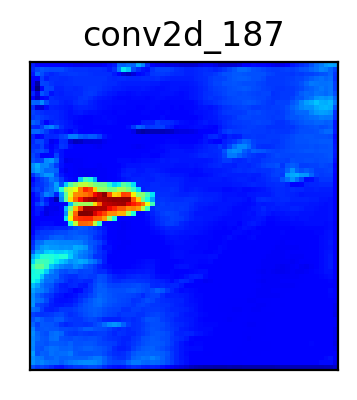

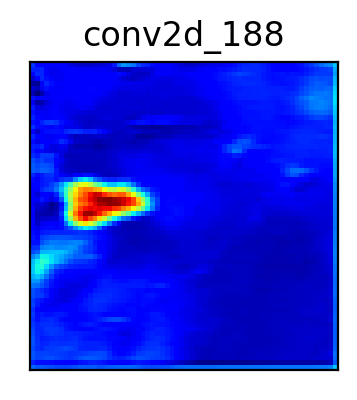

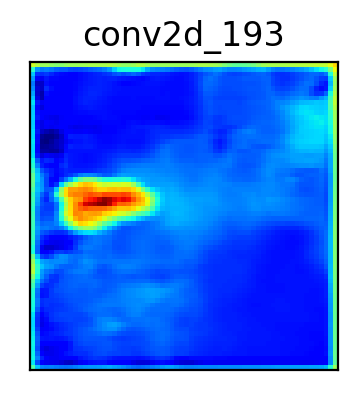

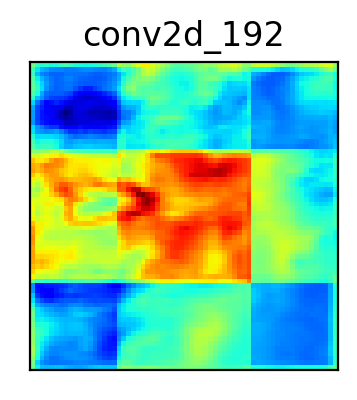

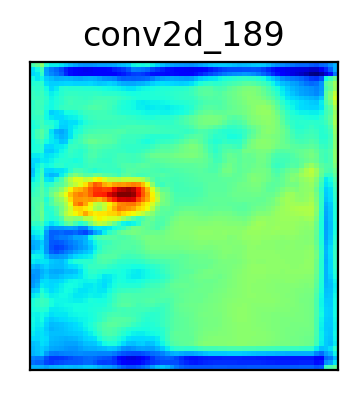

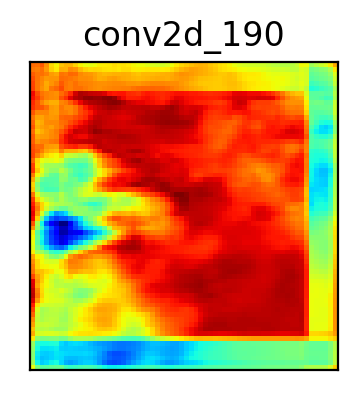

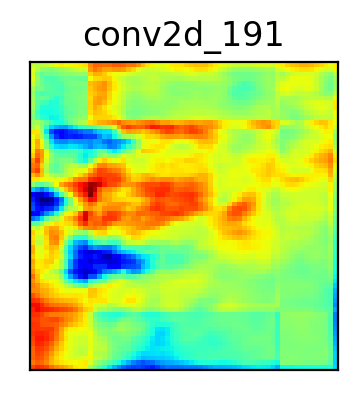

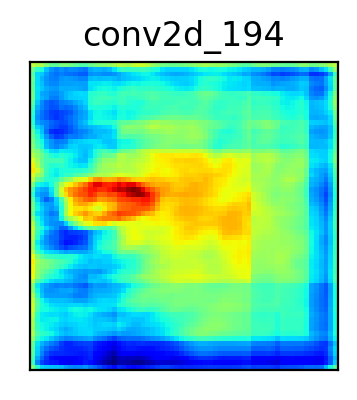

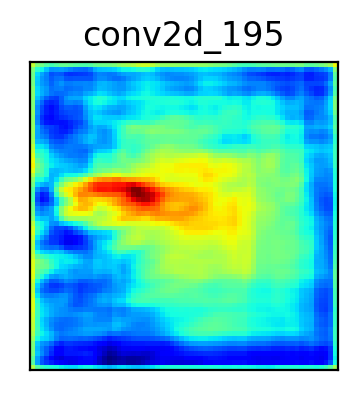

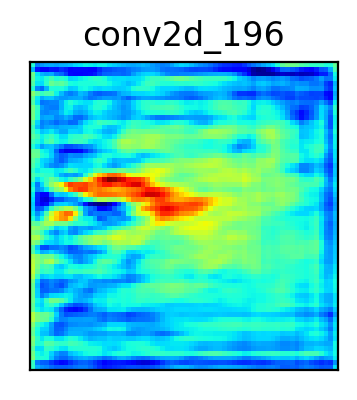

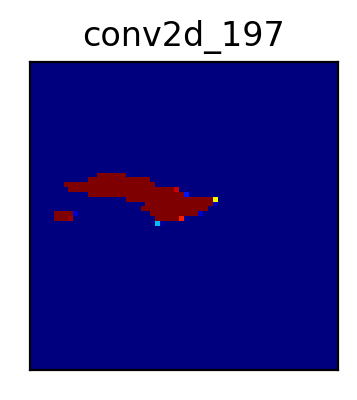

In [20]:
# Initialize a counter variable 'c' to keep track of the layer being processed
c = 0

# Iterate through the CAMs generated for different layers
for cam in cams:
    # Create a new figure with a small size and high DPI
    plt.figure(figsize=(2, 2), dpi=200)
    
    # Display the CAM as an image with a 'jet' colormap
    plt.imshow(cam, cmap='jet')
    
    # Remove x and y tick labels
    plt.xticks([])
    plt.yticks([])
    
    # Set the title of the subplot to the name of the corresponding layer
    plt.title(layers_name[c])
    
    # Show the current CAM
    plt.show()

    # Increment the counter to move to the next layer's CAM
    c = c + 1
